# Work through Geometric Factor for Sullivan 1971 
* How do the results depend on stackup?
    * Both the full formula and a bounded formula
* How do the results depend on diameter?
    * Both the full formula and a bounded formula
    
$G=\frac{1}{2}\pi^2 \left[R_1^2+R_2^2+l^2 -\left\{\left(R_1^2+R_2^2+l^2\right)^2-4R_1^2R_2\right\}^{\frac{1}{2}}   \right]$

$G \ge \frac{A_1A_2}{R_1^2+R_2^2+l^2}$

In [1]:
from pprint import pprint 

import numpy as np
import pymc3 as mc3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 3})

/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def getBoundedNormal_dist(mean=None, FWHM=None, name=None, lower=0, upper=1e6):
    """
    Make a bounded normal distribution

    NOTE: https://github.com/pymc-devs/pymc3/issues/1672 bounded dist fail until 3.1 on
    non array bounds!!
    """
    assert mean is not None
    assert FWHM is not None
    assert name is not None
    BoundedNormal = mc3.Bound(mc3.Normal, lower=np.asanyarray(lower), upper=np.asanyarray(upper))
    return BoundedNormal('{0}'.format(name), mu=mean, sd=FWHMtoSD_Normal(mean * (FWHM / 100.)))

def Sullivan_Bound(R1, R2, l):
    A1 = np.pi*R1**2
    A2 = np.pi*R2**2
    top = A1*A2
    bottom = R1**2+R2**2+l**2
    return top/bottom

def Sullivan(R1, R2, l):
    f = 0.5*np.pi**2
    t1 = R1**2+R2**2+l**2
    t2 = 4*R1**2*R2**2
    G = f*(t1 - (t1**2-t2)**0.5 )
    return G

def frac_bounds(trace):
    med = np.median(trace)
    bounds = np.percentile(trace, (2.5, 97.5))
    frac = (med-bounds[0])/med
    return med, frac*100

## Just thickness
### Stack up five colimator discs to compute G  

In [3]:
Sullivan(4, 5, 10)

28.586083706031708

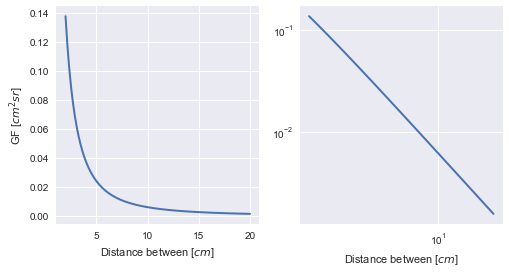

In [4]:
R1 = 0.5
R2 = 0.5
l = np.linspace(2, 20, 100)
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].plot(l, Sullivan(R1, R2, l), lw=2)
ax[0].set_xlabel('Distance between [$cm$]')
ax[0].set_ylabel('GF [$cm^2sr$]');

ax[1].loglog(l, Sullivan(R1, R2, l), lw=2)
ax[1].set_xlabel('Distance between [$cm$]');


In [5]:
with mc3.Model() as model1:
    T1 = mc3.Normal('T1', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T2 = mc3.Normal('T2', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T3 = mc3.Normal('T3', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T4 = mc3.Normal('T4', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T5 = mc3.Normal('T5', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    R1 = 0.5
    R2 = 0.5
    R3 = 0.5
    G = mc3.Deterministic('G', Sullivan(R1, R3, T1+T2+T3+T4+T5))
    Gbound = mc3.Deterministic('Gbound', Sullivan_Bound(R1, R3, T1+T2+T3+T4+T5))
    start = mc3.find_MAP()
    trace = mc3.sample(10000, start=start, jobs=2)
    

logp = 29.944, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 561.94it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:15<00:00, 658.33it/s]


In [6]:
mc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
T1,1.000004,0.000988,5.546929e-06,0.998065,1.001955,20000.0,0.999963
T2,0.999998,0.000995,5.172380e-06,0.998070,1.001960,20000.0,0.999989
T3,1.000005,0.000993,6.181799e-06,0.998096,1.001961,20000.0,0.999975
T4,0.999997,0.000997,5.887114e-06,0.998063,1.001956,20000.0,0.999957
T5,1.000001,0.001005,7.108272e-06,0.998019,1.001960,20000.0,0.999979
G,0.024192,0.000021,1.410991e-07,0.024151,0.024234,20000.0,0.999950
Gbound,0.024190,0.000021,1.410584e-07,0.024148,0.024232,20000.0,0.999950


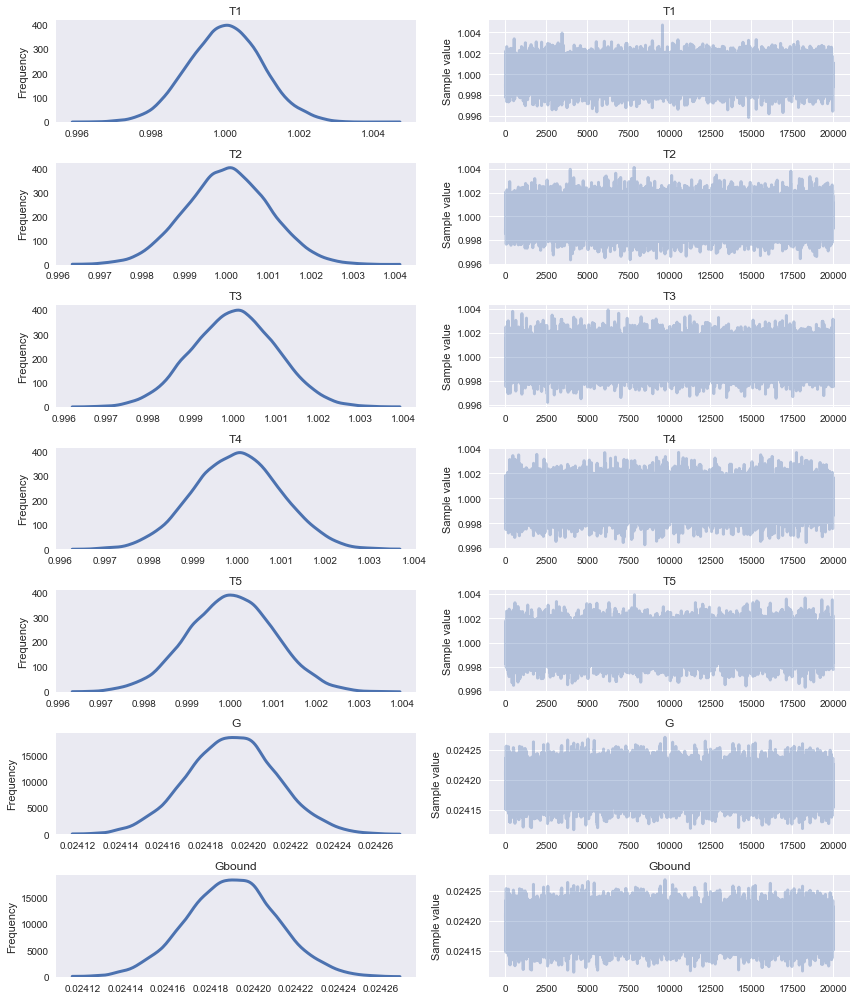

In [7]:
mc3.traceplot(trace, combined=True);

In [8]:
gf = frac_bounds(trace['G'])
gbf = frac_bounds(trace['Gbound'])
print("G={:.5f} +/- {:.2f}%".format(gf[0], gf[1]))
print("Gbound={:.5f} +/- {:.2f}%".format(gbf[0], gbf[1]))

G=0.02419 +/- 0.17%
Gbound=0.02419 +/- 0.17%


## As a function of measurement uncertainty

In [9]:
pm = np.logspace(-3, -1, 10)
ans = {}
for ii, p in enumerate(pm):
    print(p, ii+1, len(pm))
    with mc3.Model() as model2:
        T1 = mc3.Normal('T1', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T2 = mc3.Normal('T2', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T3 = mc3.Normal('T3', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T4 = mc3.Normal('T4', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T5 = mc3.Normal('T5', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        R1 = 0.5
        R2 = 0.5
        R3 = 0.5
        G = mc3.Deterministic('G', Sullivan(R1, R3, T1+T2+T3+T4+T5))
        Gbound = mc3.Deterministic('Gbound', Sullivan_Bound(R1, R3, T1+T2+T3+T4+T5))
        start = mc3.find_MAP()
        trace = mc3.sample(10000, start=start, jobs=2)
        ans[p] = gf = frac_bounds(trace['G'])


0.001 1 10


logp = 29.944, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 139.29it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:13<00:00, 798.58it/s]


0.0016681005372000592 2 10


logp = 27.386, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 506.19it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:11<00:00, 932.87it/s]


0.0027825594022071257 3 10


logp = 24.827, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 399.91it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:10<00:00, 973.79it/s]


0.004641588833612777 4 10


logp = 22.269, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 720.79it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:11<00:00, 927.25it/s]


0.007742636826811269 5 10


logp = 19.71, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 354.94it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:10<00:00, 986.58it/s]


0.01291549665014884 6 10


logp = 17.152, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 791.75it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 831.79it/s]


0.021544346900318832 7 10


logp = 14.594, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 510.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:11<00:00, 953.77it/s]


0.03593813663804626 8 10


logp = 12.035, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 652.51it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:10<00:00, 976.74it/s]


0.05994842503189409 9 10


logp = 9.4767, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 534.78it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:11<00:00, 911.24it/s]


0.1 10 10


logp = 6.9182, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 711.80it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:10<00:00, 957.81it/s]


In [10]:
pprint(ans)

{0.001: (0.024192448712898842, 0.1689826502225097),
 0.0016681005372000592: (0.024192579129585185, 0.28626776112908286),
 0.0027825594022071257: (0.024191809946623018, 0.4645715149259601),
 0.004641588833612777: (0.024193488858609655, 0.801464879395716),
 0.007742636826811269: (0.02419203552764003, 1.3415944957697834),
 0.01291549665014884: (0.024193161262647936, 2.1659772542602154),
 0.021544346900318832: (0.02419315917620691, 3.632700262045357),
 0.03593813663804626: (0.024187914920300722, 5.91064574195058),
 0.05994842503189409: (0.024190561551768748, 9.457348656901967),
 0.1: (0.024194661998894397, 15.181736606219728)}


In [11]:
vals = np.asarray(list(ans.keys()))
gs = np.asarray([ans[v][0] for v in ans ])
gse = np.asarray([ans[v][1] for v in ans ])


(0, 15)

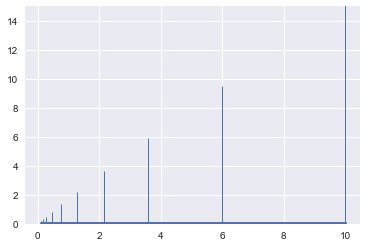

In [12]:
valsf = (vals/1.0)*100
plt.errorbar(valsf, gs, yerr=gse, elinewidth=1, capsize=2, barsabove=True)
plt.ylim([0,15])
# plt.xscale('log')

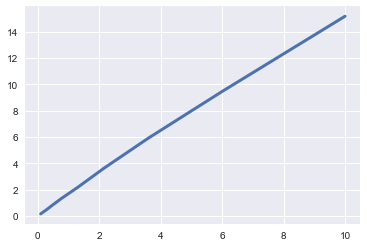

In [13]:
plt.plot(valsf, gse)
